# Predictive Modelling 
## Random Forest, Logistic Regression, AdaBoost, XGBoost, Naive Bayes, GridSearchCV, RandomizedSearchCV

Daniel, Yorrik, Dennis

In [90]:
# import some packages

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import time

In [91]:
# load data

df_imputed = pd.read_csv('application_data_clean_im_sca_bal.csv')
df_notimputed = pd.read_csv('application_data_clean2.csv')

In [92]:
q = True
if q == True:
    df_imputed = df_imputed.iloc[:,1:df_imputed.shape[1]]

df_imputed.head()
    

,TARGET,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0.0,0.035469,0.000000,0.000550,0.118921,0.116550,0.102132,0.257000,0.965220,0.982470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.168010,0.000000,0.000935,0.101124,0.039996,0.102132,1.000000,0.522717,0.975100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.215111,0.000000,0.000935,0.140449,0.093805,0.141414,0.206749,0.672886,0.983028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.074927,0.105263,0.001704,0.266876,0.203194,0.214366,0.030685,0.570913,0.790531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.237873,0.000000,0.000973,0.310449,0.140611,0.270483,0.245631,0.335287,0.827937,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline', linewidth=3)
    plt.plot(model_fpr, model_tpr, 'r', label = 'model', linewidth=3)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [94]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (12,8))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#3296c8', \
          label = "Feature Weight") #'#00A000'
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#c8dcb4', \
          label = "Cumulative Feature Weight")  #'#0AA0A0' '#96c896'
    plt.xticks(np.arange(10), columns, rotation=45)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.savefig('ROC_XGB.png', dpi=500)
    plt.show()
    

## XGBoost without undersampling, scaling, balancing and imputation

In [96]:
# XGBoost without undersampling, scaling and imputation
# XGBoost is able to perform with NaNs!


y1 = df_notimputed.TARGET
x1 = df_notimputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.25, random_state=10)

model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [99]:
from sklearn.model_selection import cross_val_score
recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.006111623288109261 [0.00562852 0.00643259 0.00616457 0.00831099 0.00402145]
Precision 0.5842853799344672 [0.61764706 0.61538462 0.575      0.59615385 0.51724138]
F1 0.012092023688633819 [0.01115538 0.0127321  0.01219836 0.01639344 0.00798085]


In [97]:
y_pred_xgb=model.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70705
           1       0.57      0.01      0.01      6172

   micro avg       0.92      0.92      0.92     76877
   macro avg       0.75      0.50      0.49     76877
weighted avg       0.89      0.92      0.88     76877



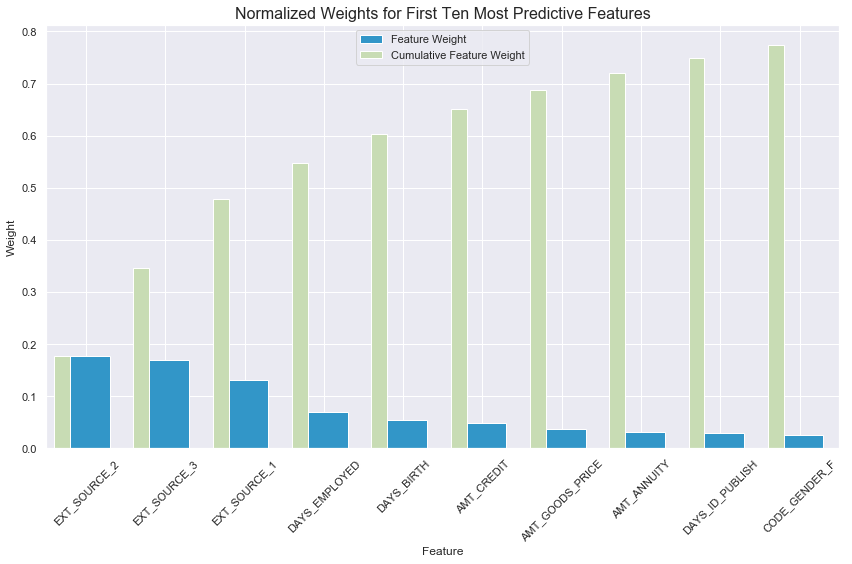

In [98]:
# Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

In [ ]:
# Make probability predictions
train_probs = model.predict_proba(x_train)[:, 1]
probs = model.predict_proba(x_test)[:, 1]

train_predictions = model.predict(x_train)
predictions = model.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

## XGBoost with undersampling, scaling, balancing and imputation

In [10]:
# XGBoost with undersampling, scaling and imputation
# XGBoost is able to perform with NaNs!

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)


t = time.time()
model = XGBClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred_xgb=model.predict(x_test)
elapsed = time.time() - t
elapsed

20.748780965805054

In [62]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.69      6154
         1.0       0.69      0.67      0.68      6259

   micro avg       0.68      0.68      0.68     12413
   macro avg       0.68      0.68      0.68     12413
weighted avg       0.68      0.68      0.68     12413



In [64]:
from sklearn.model_selection import cross_val_score
recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.6730582022644971 [0.67447496 0.67654188 0.67573391 0.66792351 0.67061675]
Precision 0.6814649813045444 [0.6797829  0.68502863 0.68439716 0.67667121 0.68144499]
F1 0.6772343404160965 [0.67711853 0.68075881 0.68003795 0.67226891 0.67598751]


In [27]:
x =[0.67711853, 0.68075881, 0.68003795, 0.67226891, 0.67598751]
(max(x)-min(x))*100/2

0.4244950000000025

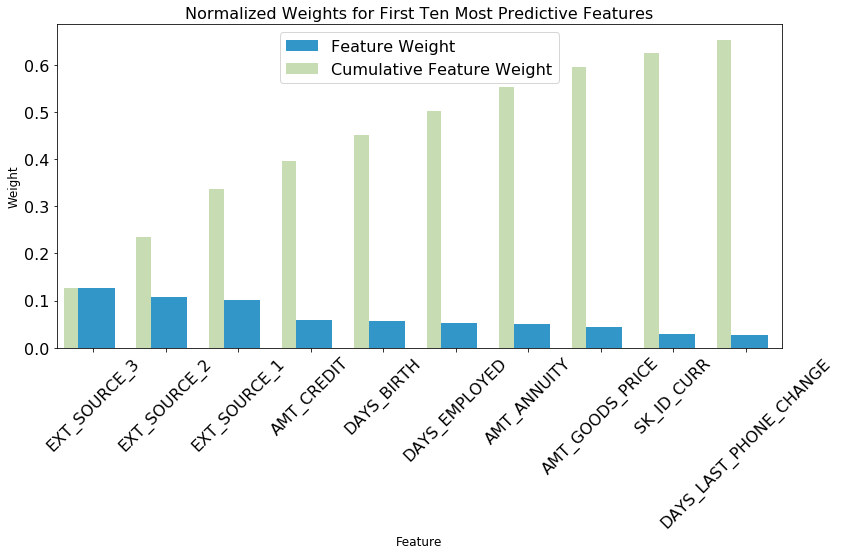

In [64]:
# Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)
# plt.savefig('Features_XGB.png', dpi=500);

Recall Baseline: 1.0 Test: 0.67 Train: 0.69
Precision Baseline: 0.5 Test: 0.69 Train: 0.69
Roc Baseline: 0.5 Test: 0.75 Train: 0.77


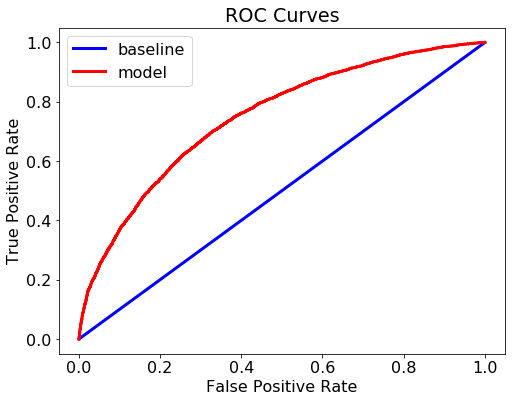

In [71]:
# Make probability predictions
train_probs = model.predict_proba(x_train)[:, 1]
probs = model.predict_proba(x_test)[:, 1]

train_predictions = model.predict(x_train)
predictions = model.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)
plt.savefig('ROC_XGB.png', dpi=500)

In [20]:
from sklearn.metrics import roc_auc_score

train_probs = model.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

0.7652419320049082

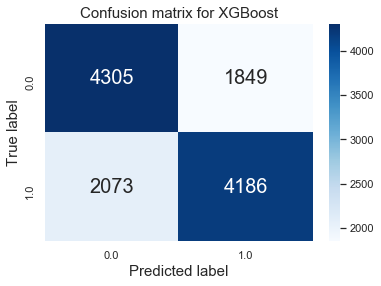

In [88]:
import seaborn as sns
sns.set()
confusion_matrix = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,annot_kws={'size': 20},fmt='g',cmap='Blues');

plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix for XGBoost', fontsize=15)
plt.savefig('Confusion.png', dpi=500)

## Adaboost

In [11]:
# Adaboost Classifier with undersampling, scaling and imputation

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

t = time.time()
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
y_pred_ada=ada.predict(x_test)
elapsed = time.time() - t
elapsed


7.025880813598633

In [14]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68      6154
         1.0       0.69      0.67      0.68      6259

   micro avg       0.68      0.68      0.68     12413
   macro avg       0.68      0.68      0.68     12413
weighted avg       0.68      0.68      0.68     12413



In [28]:
recall = cross_val_score(ada, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(ada, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(ada, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.6718732782009563 [0.6725902  0.67277134 0.67142472 0.67088608 0.67169405]
Precision 0.6838422778298454 [0.67678136 0.68588688 0.69077307 0.67433676 0.69143332]
F1 0.6777868641364402 [0.67467927 0.67926581 0.68096149 0.67260699 0.68142077]


In [34]:
x =[0.67467927, 0.67926581, 0.68096149, 0.67260699, 0.68142077]
(max(x)-min(x))*100/2

0.0035201999787602732

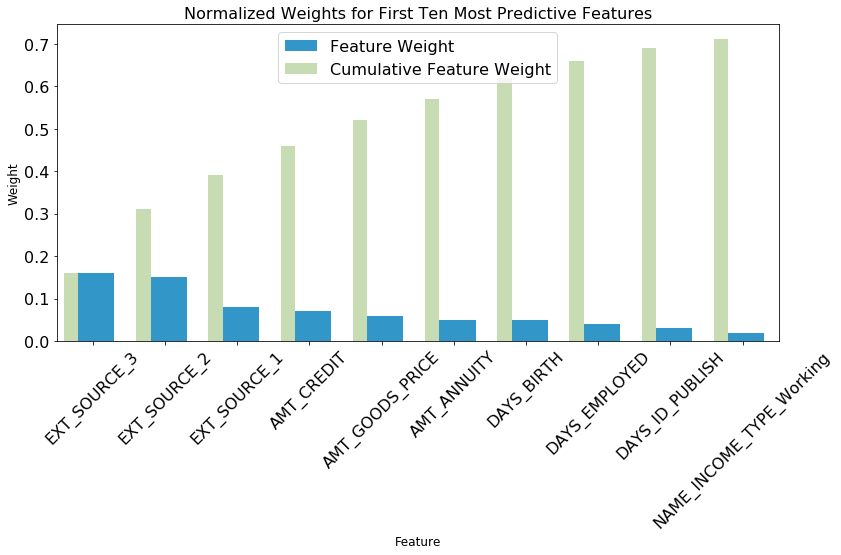

In [15]:
# Extract the feature importances
importances = ada.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

Recall Baseline: 1.0 Test: 0.67 Train: 0.68
Precision Baseline: 0.5 Test: 0.69 Train: 0.69
Roc Baseline: 0.5 Test: 0.75 Train: 0.76


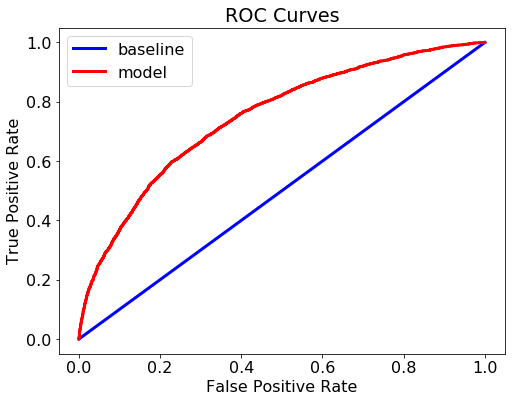

In [64]:
# Make probability predictions
train_probs = ada.predict_proba(x_train)[:, 1]
probs = ada.predict_proba(x_test)[:, 1]

train_predictions = ada.predict(x_train)
predictions = ada.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [32]:
from sklearn.metrics import roc_auc_score

train_probs = ada.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

0.7559515046289933

## Random Forest

In [12]:
# Random Forest with imputation, scaling and random undersampling 

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

# Run random forest classifier
t = time.time()
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 10, verbose = 1, n_jobs = -1)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
elapsed = time.time() - t
elapsed

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


3.5760488510131836

In [13]:
# show classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.68      6154
         1.0       0.68      0.65      0.66      6259

   micro avg       0.67      0.67      0.67     12413
   macro avg       0.67      0.67      0.67     12413
weighted avg       0.67      0.67      0.67     12413



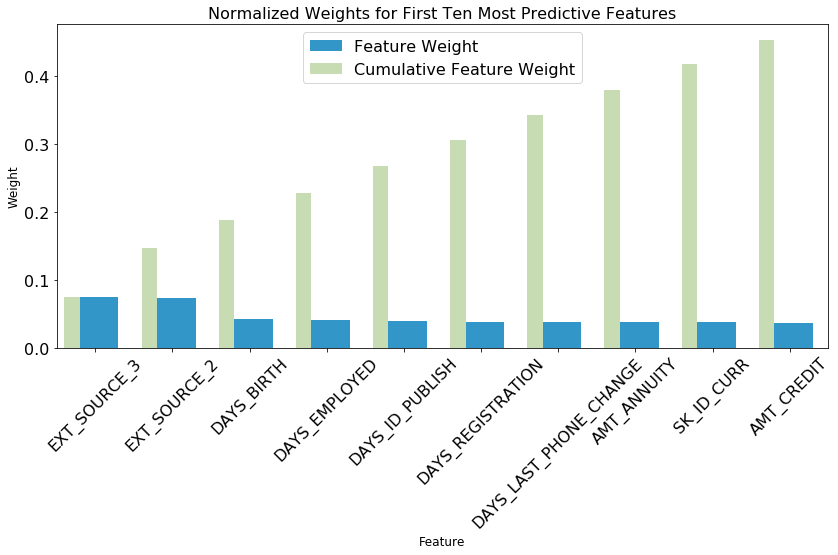

In [17]:
# Extract the feature importances
importances = random_forest.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Recall Baseline: 1.0 Test: 0.65 Train: 1.0
Precision Baseline: 0.5 Test: 0.68 Train: 1.0
Roc Baseline: 0.5 Test: 0.73 Train: 1.0


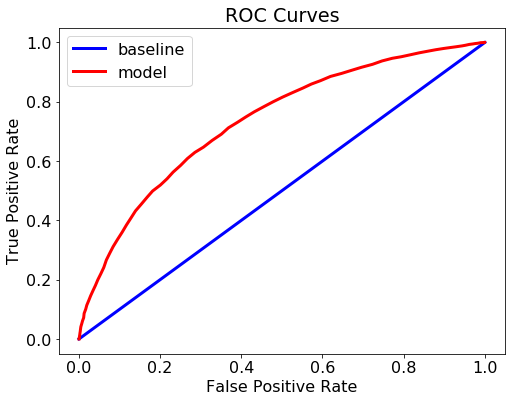

In [18]:
# Make probability predictions
train_probs = random_forest.predict_proba(x_train)[:, 1]
probs = random_forest.predict_proba(x_test)[:, 1]

train_predictions = random_forest.predict(x_train)
predictions = random_forest.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

## Random Forest best parameters with RandomizedSearchCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 10)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=10)

# Fit
t = time.time()

rs.fit(x_train, y_train)

best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(x_train)

train_rf_probs = best_model.predict_proba(x_train)[:, 1]

rf_predictions = best_model.predict(x_test)
rf_probs = best_model.predict_proba(x_test)[:, 1]

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

elapsed = time.time() - t
elapsed

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


197.16606211662292

In [53]:
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Average number of nodes 81
Average maximum depth 7


In [54]:
rs.best_params_

{'n_estimators': 161,
 'min_samples_split': 5,
 'max_leaf_nodes': 41,
 'max_features': 0.5,
 'max_depth': 7,
 'bootstrap': True}

## Random Forest with best parameters

In [46]:
# Random Forest with best parameters

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

# Run random forest classifier
t = time.time()
random_forest = RandomForestClassifier(n_estimators=161,min_samples_split=5,max_leaf_nodes=41, max_features=0.5, max_depth=7,random_state = 10, verbose = 1, n_jobs = -1)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
elapsed = time.time() - t
elapsed

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished


11.08054780960083

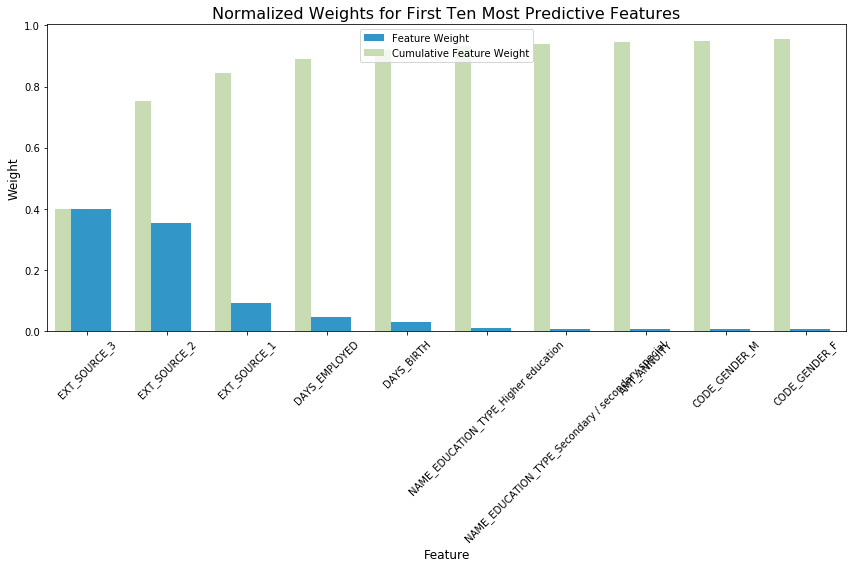

In [47]:
# Extract the feature importances
importances = random_forest.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished


Recall Baseline: 1.0 Test: 0.66 Train: 0.67
Precision Baseline: 0.5 Test: 0.68 Train: 0.68
Roc Baseline: 0.5 Test: 0.73 Train: 0.75


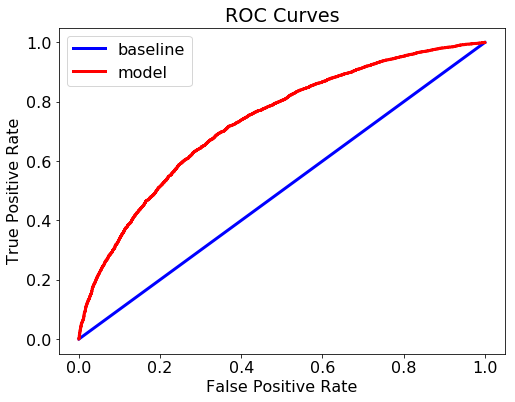

In [48]:
# Make probability predictions
train_probs = random_forest.predict_proba(x_train)[:, 1]
probs = random_forest.predict_proba(x_test)[:, 1]

train_predictions = random_forest.predict(x_train)
predictions = random_forest.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

In [49]:
from sklearn.metrics import roc_auc_score

train_probs = random_forest.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.2s finished


0.7450627295379844

In [50]:
recall = cross_val_score(random_forest, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(random_forest, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(random_forest, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]:

Recall 0.6621246922244552 [0.65508885 0.66307568 0.66092109 0.65903582 0.67250202]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]:

Precision 0.6720684711597732 [0.66951018 0.67341357 0.67865044 0.67022733 0.66854083]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]:

F1 0.6670388267284031 [0.66222101 0.66820464 0.66966844 0.66458446 0.67051557]


[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.0s finished


In [53]:
x =[0.66951018, 0.67341357, 0.67865044, 0.67022733, 0.66854083]
(max(x)-min(x))*100/2

0.5054804999999996

## Logistic Regression

In [15]:
# LOGISTIC REGRESSION with imputation, scaling and random undersampling


y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

t = time.time()

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_log=lr.predict(x_test)
elapsed = time.time() - t
elapsed

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.4025180339813232

In [56]:
print(classification_report(y_test, y_pred_log))

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      6154
         1.0       0.69      0.66      0.68      6259

   micro avg       0.68      0.68      0.68     12413
   macro avg       0.68      0.68      0.68     12413
weighted avg       0.68      0.68      0.68     12413



In [35]:
recall = cross_val_score(lr, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(lr, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(lr, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

Recall 0.6678342594337002 [0.65697361 0.67196337 0.66953946 0.66927013 0.67142472]


//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

Precision 0.6794529436181446 [0.67014556 0.6848751  0.68409466 0.67325928 0.68489011]


//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

F1 0.6735880368079987 [0.66349422 0.6783578  0.6767388  0.67125878 0.67809058]


In [38]:
x =[0.65697361, 0.67196337, 0.66953946, 0.66927013, 0.67142472]
(max(x)-min(x))*100/2

0.7494879999999982

In [39]:
from sklearn.metrics import roc_auc_score

train_probs = lr.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

0.7473780079357434

## Naive Bayes

In [16]:
# Naive Bayes with imputation, scaling and random undersampling

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

t = time.time()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

elapsed = time.time() - t
elapsed

0.1419992446899414

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.11      0.18      6154
         1.0       0.52      0.93      0.66      6259

   micro avg       0.52      0.52      0.52     12413
   macro avg       0.56      0.52      0.42     12413
weighted avg       0.56      0.52      0.43     12413



In [54]:
recall = cross_val_score(gnb, x_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(gnb, x_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(gnb, x_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9126929049442924 [0.85621971 0.92431996 0.91004579 0.93024508 0.94263399]
Precision 0.515570455847541 [0.53788904 0.51492873 0.50926903 0.5057101  0.51005538]
F1 0.658468550974473 [0.66071058 0.66139911 0.65307306 0.65522147 0.66193853]


In [18]:
confusion_matrix(y_test, y_pred) 

array([[ 662, 5492],
       [ 419, 5840]])

In [19]:
from sklearn.metrics import roc_auc_score

train_probs = gnb.predict_proba(x_train)[:, 1]

roc_auc_score(y_train, train_probs)

0.6399834080198512

## GridSearchCV

In [44]:
# GridSearchCV

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) # The F-beta score is the weighted harmonic mean of precision and 
                                           # recall, reaching its optimal value at 1 and its worst value at 0.
    
# To give more weight to the Precision, we pick a Beta value in the interval 0 < Beta < 1
# To give more weight to the Recall, we pick a Beta Value in the interval 1 < Beta < +∞

In [45]:
# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer, n_jobs=-1) # Exhaustive search over specified parameter values
                                                # for an estimator.

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(x_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

y = df_imputed.TARGET
x = df_imputed.drop(columns=['TARGET'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=10)

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [46]:
# Make predictions using the unoptimized and model
predictions = (best_clf.fit(x_train, y_train)).predict(x_test)
best_predictions = best_clf.predict(x_test)



              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      6154
         1.0       0.69      0.67      0.68      6259

   micro avg       0.69      0.69      0.69     12413
   macro avg       0.69      0.69      0.69     12413
weighted avg       0.69      0.69      0.69     12413



In [50]:
grid_obj.best_params_

{'base_estimator__max_depth': 3,
 'base_estimator__min_samples_split': 2,
 'learning_rate': 0.1,
 'n_estimators': 120}

In [47]:
print(classification_report(y_test, best_predictions))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      6154
         1.0       0.69      0.67      0.68      6259

   micro avg       0.69      0.69      0.69     12413
   macro avg       0.69      0.69      0.69     12413
weighted avg       0.69      0.69      0.69     12413



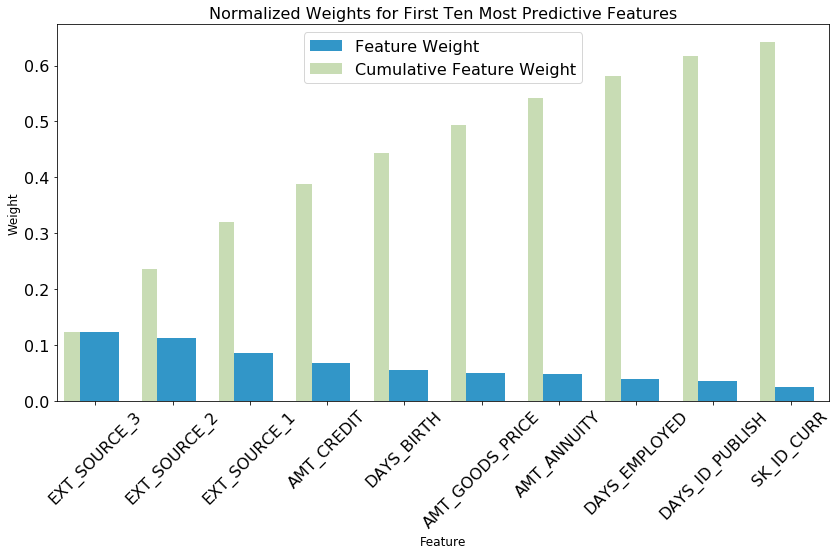

In [51]:
# Extract the feature importances
importances = best_clf.feature_importances_

# Plot
feature_plot(importances, x_train, y_train)

Recall Baseline: 1.0 Test: 0.67 Train: 0.69
Precision Baseline: 0.5 Test: 0.69 Train: 0.7
Roc Baseline: 0.5 Test: 0.75 Train: 0.77


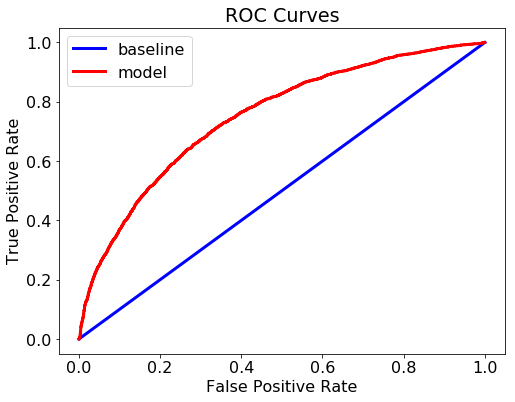

In [52]:
# Make probability predictions
train_probs = best_clf.predict_proba(x_train)[:, 1]
probs = best_clf.predict_proba(x_test)[:, 1]

train_predictions = best_clf.predict(x_train)
predictions = best_clf.predict(x_test)

train_labels = y_train.copy()
test_labels = y_test.copy()

evaluate_model(predictions, probs, train_predictions, train_probs)

# Conclusion

In [ ]:
                  RECALL          PRECISION             F1            ROC            RUN-TIME
    
 XG Boost      67.3 +- 0.4%      68.1 +- 0.4%       67.7 +- 0.4%      0.765            21 s

 ADA Boost     67.2 +- 0.1%      68.4 +- 0.9%       67.8 +- 0.4%      0.756             7 s
    
 Random Forest 66.2 +- 0.9%      67.2 +- 0.5%       66.7 +- 0.4%      0.745    197 s + 11 s

 Logistic Reg  66.8 +- 0.8%      67.9 +- 0.7%       67.4 +- 0.7%      0.747           1.4 s

# Future Work

## Principal Component Analysis

## Include Pensioners and set DAYS_EMPLOYED-Values to max

## Include other datasets (Bureau, ...)

## LightGBM

## Analysis all countries/markets

## Analysis of default rates for different credit types

#  BUSINESS RECOMMENDATIONS

### 1. Extended Search for external Sources (EXT_SRC)
### 2. StricterValidation-ChecksofyoungerCustomers
### 3. Higher Attention for Credit amounts around average